In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
set.seed(2000)
players <- read_csv("players.csv")
players

players_select <- players |>
    select(experience, played_hours, Age)

players_split <- initial_split(players_select, prop = 0.75, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`).”


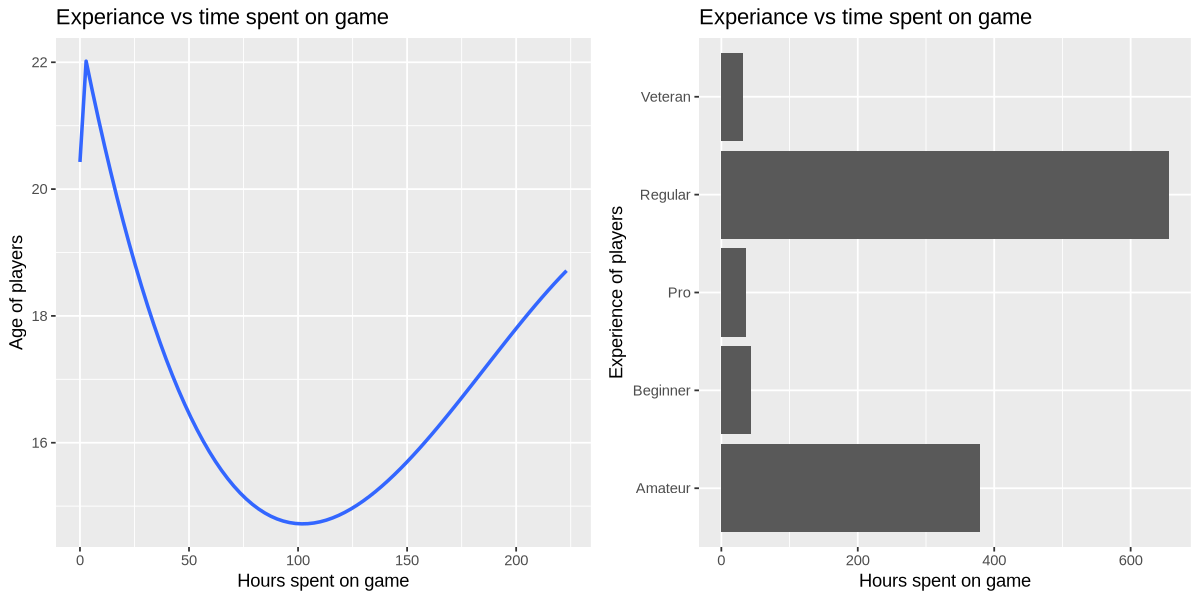

In [3]:
options(repr.plot.width=10, repr.plot.height=5)
players_plot_experience<-players_select|>
                         ggplot(aes(x=played_hours,y=experience))+
                         geom_bar(stat = "Identity")+
                         labs(x="Hours spent on game",y="Experience of players")+
                         ggtitle("Experiance vs time spent on game")
                         
                              

players_plot_Age<-players_select|>
                         ggplot(aes(x=played_hours,y=Age))+
                         geom_smooth(method = "auto", se = FALSE)+
                         labs(x="Hours spent on game",y="Age of players")+
                         ggtitle("Experiance vs time spent on game")
                              
plot_grid(players_plot_Age,players_plot_experience,ncol=2)

In [4]:
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |>
    set_mode("regression") 

players_recipe <- recipe(played_hours ~ ., data = players_training) |>
    step_dummy(all_nominal_predictors(), -all_outcomes()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

players_workflow <- workflow() |> 
    add_recipe(players_recipe) |> 
    add_model(players_spec)
players_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_dummy()
• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [5]:
gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

players_results <- workflow() |> 
    add_recipe(players_recipe) |> 
    add_model(players_spec) |>
    tune_grid(object = players_workflow, resamples = players_vfold, grid = gridvals) |>
    collect_metrics()
players_results

players_min <- players_results |>
    filter(.metric == "rmse") |>
    slice_min(std_err, n = 1)
players_min

Warning message:
“The `...` are not used in this function but one or more objects were passed: ''”
→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 28 rows.
               ✖ Assigned data has 29 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 29 to size 28.

There were issues with some computations   A: x1

→ B | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 27 rows.
               ✖ Assigned data has 28 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 28 to size 27.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,4.47149293,3,0.74484142,Preprocessor1_Model01
1,rsq,standard,0.02564307,3,0.01912864,Preprocessor1_Model01
6,rmse,standard,5.18000601,3,0.38360783,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
91,rsq,standard,0.03540785,3,0.01585044,Preprocessor1_Model19
96,rmse,standard,4.29485515,3,0.90738508,Preprocessor1_Model20
96,rsq,standard,0.02327623,3,0.01547871,Preprocessor1_Model20


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,rmse,standard,5.180006,3,0.3836078,Preprocessor1_Model02


In [8]:
k_min <- players_min |>
          pull(neighbors)

players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
          set_engine("kknn") |>
          set_mode("regression")

players_best_fit <- workflow() |>
          add_recipe(players_recipe) |>
          add_model(players_best_spec) |>
          fit(data = players_training)
players_best_fit

players_summary <- players_best_fit |>
           predict(players_testing) |>
           bind_cols(players_testing) |>
           metrics(truth = played_hours, estimate = .pred)
players_summary

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_dummy()
• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(6,     data, 5), kernel = ~"rectangular")

Type of response variable: continuous
minimal mean absolute error: 3.292708
Minimal mean squared error: 77.61652
Best kernel: rectangular
Best k: 6

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,55.0234884
rsq,standard,0.0119053
mae,standard,16.3600000


In [9]:
player_preds <- players_best_fit |>
predict(players_training) |>
bind_cols(players_training)
player_preds

marathon_plot <- player_preds |>
    ggplot(aes(x = max, y = time_hrs)) +
    geom_point() +
    geom_line(mapping = aes(x = , y = .pred), color = "blue") +
    labs(x = "Maximum Distance", y = "Time Taken (hrs)", title = "Time Taken to Run Distance per Week ")
marathon_plot

ERROR: [1m[33mError[39m in `bind_cols()`:[22m
[33m![39m Can't recycle `..1` (size 144) to match `..2` (size 146).
